In [84]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests
from dotenv import load_dotenv
from scipy.optimize import minimize, Bounds, NonlinearConstraint
from functools import partial 

load_dotenv("/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/hidden.env")
%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import *
from Region import * 
from Individual import * 
from Pairwise import * 


def remove_identical_lines(function):
    lines = function.split("\n")
    unique_lines = []
    for line in lines: 
        if line not in unique_lines:
            unique_lines.append(line)
    return("\n").join(unique_lines)

In [85]:
api_key = os.getenv('OPENAI_API_KEY')
client = openai.Client(api_key=api_key)
# If you're setting the API key directly in your script, uncomment the next line 

def room_setup(scene_descriptor, api_key=api_key):
    url = 'https://api.openai.com/v1/chat/completions'
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Content-Type': 'application/json',
            }
    
    # Read the contents of the .py file
    file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
    with open(file_path, 'r') as file:
        file_contents = file.read()

    prompt1 = "I am designing the layout for" + scene_descriptor + ". Please give me the dimensions of the room,"
    prompt1 += """ as well as the number of windows, doors, and sockets. For each window, door, and socket tell me the dimensions (in meters),
    which wall it should be on, as well as where on the wall it should be (this is a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up:
    {Room: width = 5,  length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}, etc.
    The windows and doors should all have length 0.1. Ensure that every object has dimensions, position, and wall.
     No other text please. Just the list with no commentary or explanation."""
    response1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt1}],
        max_tokens=500
    )
    objects = response1.choices[0].message.content.split("}, {")
    prompt2 = "I am going to give you a set of functions that are used to create a room and put objects in it. The functions are as follows:"
    prompt2 += file_contents
    prompt2 += f"I now want, for each element in this list: {objects}, with room descriptor:" + scene_descriptor + ", for you to translate it into a function call using the functions I gave you above."
    prompt2 += " For example, given the room descriptor 'a small kitchen' as well as the list: "
    prompt2 += "{Room: width = 5,  length = 6}, {Object type: window, Number: 1,  width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:"
    prompt2 += "kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3)."
    prompt2 += " Return only the python script. No other text. Please ensure the correct number of inputs are given for each function."

    # Define the request payload
    data = {
        "model": "gpt-4",
        "messages": [
            {"role": "user", "content": prompt2}
        ]
    }
    
    # Make the API call
    response2 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response2.status_code == 200:
        response_data2 = response2.json()
        if "```python" in response_data2['choices'][0]['message']['content']:
            response2 = (response_data2['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        elif "```" in response_data2['choices'][0]['message']['content']:
            response2 = (response_data2['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
        else: 
            response2 = response_data2['choices'][0]['message']['content']
        print(response2)
        exec(response2)
    else:
        print('Failed to get a response')
        print(response2.text)

    return response1, response2

scene_descriptor = "a bedroom for a student in a university dormitory"
response1, response2 = room_setup(scene_descriptor)

width = (response2.split("create_room("))[1].split(",")[0]
length = (response2.split("create_room("))[1].split(",")[1].split(")")[0]
room_name = ((response2).split(" =")[0]).split("\n")[-1]

room = create_room(4, 5)
create_fixed_object(room, 'door', 0.9, 0.1, 'north', 0.2)
create_fixed_object(room, 'window', 1.2, 0.1, 'east', 0.5)
create_fixed_object(room, 'socket', 0.1, 0.1, 'west', 0.3)
create_fixed_object(room, 'socket', 0.1, 0.1, 'south', 0.8)
create_fixed_object(room, 'socket', 0.1, 0.1, 'north', 0.7)


In [86]:
lang_prompt1 = "I am designing the layout of a" +  scene_descriptor + "that is" + width + "m x " + length + "m."
lang_prompt1 += """Interior designers suggest that a good layout will have different regions in the room for different functions.
What regions should I use, and how many regions should there be based on the description (minimum is 1 region and maximum is 5) """ + scene_descriptor + """, as well 
as the size of the room (if the room is small, don't give too many regions). Return this as a simple bullet list of regions to include, if there are choices to be made e.g. which of the regions
or how many regions, please make those choices. Only return the list of regions and the number of regions. No other information please."""

lang1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt1}],
        max_tokens=500
    )

print(lang1.choices[0].message.content)

lang_prompt2 = """Now for each one of the regions returned in this:""" + lang1.choices[0].message.content + """, what is the most important object to include (per region), and what are its dimensions 
(give width of back of object and length of side of object not height) all in meters. ONLY one object per region. The size of the room is"""  + width + "m x " + length + """m, 
bear this in mind when choosing the objects and the size of the objects.
Give no other information please."""


lang2 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt2}],
        max_tokens=2000
    )

print(lang2.choices[0].message.content)

lang_prompt3 = """For each of these objects""" + lang2.choices[0].message.content + """, tell me all of the considerations and constraints for its placement 
within the room that depends only on fixed features in the room like walls, windows, doors, sockets, etc... 
(return these as a bullet list for each object). Include practical things like whether it should be against a wall 
and what side (one of: left, right, top/back, bottom/front) of it should be against a wall (don't describe this as long or short side, if its something like a headboard or the back of a sofa that would be 'back' etc.), or which side should be accessible for use etc. 
Only give these constraints and considerations, no other information. """
lang3 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt3}],
        max_tokens=2000
    )

print(lang3.choices[0].message.content)

lang_prompt4 = """ Tell me all of the constraints and considerations between the objects in this list""" + lang3.choices[0].message.content + """ that depend only on each other.
For example, maybe a desk should not be close to a bed, etc. Only give the constraints and considerations between objects, no other information.."""

lang4 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt4}],
        max_tokens=2000
    )

print(lang4.choices[0].message.content)

- Sleeping area
- Study area
- Storage area
- Sleeping area: Bed, 1.4m x 2m
- Study area: Desk, 1.2m x 0.6m
- Storage area: Wardrobe, 1m x 0.6m
### Bed (1.4m x 2m)
- Back of bed (headboard) should be against a wall.
- Avoid placement under windows to prevent draft and sunlight disturbance.
- Ensure sufficient space for movement around the bed.
- Avoid placement near doors to prevent obstruction.
- Ensure both sides of the bed are slightly accessible for making the bed.

### Desk (1.2m x 0.6m)
- The bottom/front of the desk should be against a wall for stability.
- Preferably place near a window for natural light.
- Ensure access to a power socket for electrical devices.
- Avoid placing where it obstructs doors or pathways.
- Ensure enough space on one side for a chair and free movement.

### Wardrobe (1m x 0.6m)
- Back of the wardrobe should be against a wall.
- Avoid placing it near windows to prevent interference with natural light and view.
- Ensure placement does not obstruct doors

In [87]:
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json',
        }

# Read the contents of the .py file
file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
with open(file_path, 'r') as file:
    file_contents = file.read()

prompt3 = "Given the room name: " + room_name + ", and the regions: " + lang1.choices[0].message.content
prompt3 += " Using the functions in the script, initialise each region. For example 'eating region' might output 'eating_region = region_setup(kitchen, 'eating', 0)."
prompt3 += " No other text please, only the python script. Don't include the room so far in the output."
prompt3 += file_contents
 # Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
            {"role": "user", "content": prompt3}
            ]
    }
    
# Make the API call
response3 = requests.post(url, headers=headers, json=data)  
# Check the response
if response3.status_code == 200:
    response_data3 = response3.json()
    if "```python" in response_data3['choices'][0]['message']['content']:
        response3 = response2 + "\n" + (response_data3['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    else: 
        response3 = response2 + "\n" + response_data3['choices'][0]['message']['content']
        print(response3)
        global_context = globals().copy()
        local_context = {}  
        exec(response3, global_context, local_context)
else:
    print('Failed to get a response')
    print(response3.text)

room = create_room(4, 5)
create_fixed_object(room, 'door', 0.9, 0.1, 'north', 0.2)
create_fixed_object(room, 'window', 1.2, 0.1, 'east', 0.5)
create_fixed_object(room, 'socket', 0.1, 0.1, 'west', 0.3)
create_fixed_object(room, 'socket', 0.1, 0.1, 'south', 0.8)
create_fixed_object(room, 'socket', 0.1, 0.1, 'north', 0.7)
sleeping_area = region_setup(room, 'sleeping', 0)
study_area = region_setup(room, 'study', 1)
storage_area = region_setup(room, 'storage', 2)


In [88]:
fixed_objects = ""
for i in range(len(local_context[room_name].fixed_objects)):
    if i < len(local_context[room_name].fixed_objects) - 1:
        fixed_objects +=local_context[room_name].fixed_objects[i].name + ", "
    else: 
        fixed_objects += local_context[room_name].fixed_objects[i].name + "."

room_width = local_context[room_name].width
room_length = local_context[room_name].length

region_names = ""
for i in range(len(local_context[room_name].regions)):
    if i < len(local_context[room_name].regions) - 1:
        region_names += local_context[room_name].regions[i].name + ", "
    else: 
        region_names += local_context[room_name].regions[i].name + "."
print(region_names)
num_primary_objects = len(region_names.split(","))

sleeping, study, storage.


In [89]:
prompt4 = "Given this list of the objects: " + lang2.choices[0].message.content + ", use the file attached to create the objects with the correct parameters."
prompt4 += "The room name is: " + room_name + ", the region names are: " + region_names + "."
prompt4 += "The room is already set up, only add in the objects using the 'create_moving_object' function."
prompt4 += "The objects should be added in the correct regions."
prompt4 += "This is the file: " + file_contents
prompt4 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt4}
            ]
    }
    
# Make the API call
response4 = requests.post(url, headers=headers, json=data)  
# Check the response
if response4.status_code == 200:
    response_data4 = response4.json()
    if "```python" in response4.json()['choices'][0]['message']['content']:
        response4 = response3 + "\n" + (response_data4['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
    elif "```" in response4.json()['choices'][0]['message']['content']:
        response4 = response3 + "\n" + (response_data4['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
    else:
        response4 = response3 + "\n" + response_data4['choices'][0]['message']['content']

    print(response4)
    global_context = globals().copy()
    local_context = {}  
    exec(response4, global_context, local_context)
else:
    print('Failed to get a response')
    print(response4.text)

strings = response4.split("create_moving_object(" + room_name + ", '")
primary_objects = []
for string in strings[1:]:
    primary_objects.append(string.split("'")[0])

room = create_room(4, 5)
create_fixed_object(room, 'door', 0.9, 0.1, 'north', 0.2)
create_fixed_object(room, 'window', 1.2, 0.1, 'east', 0.5)
create_fixed_object(room, 'socket', 0.1, 0.1, 'west', 0.3)
create_fixed_object(room, 'socket', 0.1, 0.1, 'south', 0.8)
create_fixed_object(room, 'socket', 0.1, 0.1, 'north', 0.7)
sleeping_area = region_setup(room, 'sleeping', 0)
study_area = region_setup(room, 'study', 1)
storage_area = region_setup(room, 'storage', 2)
create_moving_object(room, 'bed', 1.4, 2.0, 'sleeping', 0)
create_moving_object(room, 'desk', 1.2, 0.6, 'study', 1)
create_moving_object(room, 'wardrobe', 1.0, 0.6, 'storage', 2)


In [101]:
file_path3 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Individual.py'
with open(file_path3, 'r') as file:
    file_contents3 = file.read()

file_path4 = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/BlankConstraints/Pairwise.py'
with open(file_path4, 'r') as file:
    file_contents4 = file.read()


prompt5 = "Given the room name: " + room_name + ", as well as the primary objects: " + str(primary_objects)
prompt5 += ", as well as their indices " +  str([i for i in range(num_primary_objects)]) + "\n " + lang3.choices[0].message.content
prompt5 += """ . Using the script attached, transform each constraint into function calls that will ensure that the primary objects are set up correctly. 
Match each constraint to the closest function in the script file by using the docstrings. If you cannot find a function that matches the constraint,
leave it out. Here is the first script: """
prompt5 += file_contents3
prompt5 += "For the second script, I want you to transform the pairwise constraints into function calls. Here is the second script: " + file_contents4
prompt5 += " and here is the list of pairwise constraints: " + lang4.choices[0].message.content
prompt5 += """. I want the output to begin with: def optimize_primary_objects(positions, room): \n output = 0, 
followed by each constraint function call added to the output, and then the output returned. Ensure to include the 
functions ind_in_bounds, and ind_no_overlap. No extra text please, only the functions and the output.  DON'T include any previous code.
 DON'T have 'python' at the start of the code. Do not define ANY functions, only call them. ENSURE that all parameters match docstrings."""

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt5}
            ]
    }
    
# Make the API call
response5 = requests.post(url, headers=headers, json=data)  
# Check the response
if response5.status_code == 200:
    response_data5 = response5.json()

    if "```python" in response5.json()['choices'][0]['message']['content']:
        response5 = response4 + "\n" + (response_data5['choices'][0]['message']['content'].split("```python")[1]).split("```")[0]
        print(response5)

    elif "```" in response5.json()['choices'][0]['message']['content']:
        response5 = response4 + "\n" + (response_data5['choices'][0]['message']['content'].split("```")[1]).split("```")[0]
        print(response5)
    else:
        response5 = response4 + "\n" + response_data5['choices'][0]['message']['content']
        response5 = remove_identical_lines(response5)
        print(response5)

    global_context = globals().copy()
    local_context = {}  
    exec(response5, global_context, local_context)
else:
    print('Failed to get a response')
    print(response5.text)


room = create_room(4, 5)
create_fixed_object(room, 'door', 0.9, 0.1, 'north', 0.2)
create_fixed_object(room, 'window', 1.2, 0.1, 'east', 0.5)
create_fixed_object(room, 'socket', 0.1, 0.1, 'west', 0.3)
create_fixed_object(room, 'socket', 0.1, 0.1, 'south', 0.8)
create_fixed_object(room, 'socket', 0.1, 0.1, 'north', 0.7)
sleeping_area = region_setup(room, 'sleeping', 0)
study_area = region_setup(room, 'study', 1)
storage_area = region_setup(room, 'storage', 2)
create_moving_object(room, 'bed', 1.4, 2.0, 'sleeping', 0)
create_moving_object(room, 'desk', 1.2, 0.6, 'study', 1)
create_moving_object(room, 'wardrobe', 1.0, 0.6, 'storage', 2)
def optimize_primary_objects(positions, room): 
    output = 0
    
    output += ind_in_bounds(positions, room) 
    output += ind_no_overlap(positions, room) 

    # Bed constraints
    output += ind_next_to_wall(positions, room, 0, 'back') 
    output += ind_away_from_fixed_object(positions, room, 0, 'window') 
    output += ind_away_from_fixed_object(p

In [124]:
primary_accessible_constraints = []
for i in response5.split("\n"):
    if "output +=" in i:
        primary_accessible_constraints.append(i)

primary_accessible_constraints = "\n" +("\n").join(primary_accessible_constraints)

In [126]:
lang_prompt5 = "Here is a description of a room: " + scene_descriptor + ". These are the regions within the room: " + region_names + "."
lang_prompt5 += "These are the primary objects within the room: " + str(primary_objects) + "."
lang_prompt5 += "And this is the size of the room: width = " + str(room_width) + " meters, length = " + str(room_length) + " meters."
lang_prompt5 += """ Give me 0-5 (depending on the size of the room) more objects that should be added into the room (so make sure they are the most appropriate/necessary objects), 
for each one, make sure that they make sense to go into one of the regions, and tell me which region they should go into. 
There can be more than one of each object kind (eg. multiple dining chairs or multiple nightstands). Make sure to also give the dimensions of every object
in meters (width (of the back of the object) and length (side of the object)). Don't give any objects like table lamps that would go on top of other objects.
Give no other text in the response. Only the list of objects."""

lang5 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt5}],
        max_tokens=1000
    )

print(lang5.choices[0].message.content)

lang_prompt6 = """For each of these objects""" + lang5.choices[0].message.content + """, tell me all of the considerations and constraints for its placement 
within the room that depends only on fixed features in the room like walls, windows, doors, sockets, etc... 
(return these as a bullet list for each object). Include practical things like whether it should be against a wall 
and what side of the object (one of: left, right, top/back, bottom/front) of it should be against a wall (don't describe this as long or short side, if its something like a headboard or the back of a sofa that would be 'back' etc.), 
or which side should be accessible for use etc. Don't include any constraints that depend on other objects. Only give these constraints and considerations, no other information. """
lang6_1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt6}],
        max_tokens=2000
    )

lang_prompt6 = """ For all of these constraints, remove any that related to other objects. I only want constraints 
that depend on fixed features in the room like walls, windows, doors, sockets, etc. Feel free to add any extra details like minimum distances etc to existing constraints.
Don't create any new constraints. If any constraints contain two options e.g 'the bed should be against the left wall or the right wall', change it to be only one option."""
lang_prompt6 += lang6_1.choices[0].message.content
lang6 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt6}],
        max_tokens=2000
    )

print(lang6.choices[0].message.content)

lang_prompt7 = """ Tell me all of the constraints and considerations between the objects in this list""" + lang6.choices[0].message.content + """ as well as 
in this list """ + str(primary_objects) + """. For example, a desk chair should have its front against the front of the desk, or the left side of one 
of the nightstands should be against the right side of the bed, etc.  Be specific with relationships between objects to include sides (one of: left, right, top/back, bottom/front) 
if appropriate, or minimum/maximum distances between objects etc.
Only give the constraints and considerations between objects, no other information."""

lang7 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": lang_prompt7}],
        max_tokens=2000
    )

print(lang7.choices[0].message.content)

1. Nightstand, Sleeping, 0.5m width, 0.5m length
2. Bookshelf, Study, 0.8m width, 1.2m length
3. Chair, Study, 0.5m width, 0.5m length
4. Small dresser, Storage, 0.8m width, 0.5m length
Certainly! Here are the placement considerations and constraints for each object, focusing solely on fixed features in the room like walls, windows, doors, and sockets. I've removed any constraints related to other objects and ensured only one option is provided where there were multiple:

1. **Nightstand (Sleeping, 0.5m width, 0.5m length)**
    - Should be placed against a wall for stability.
    - Height should allow easy reach while lying on the bed.
    - Should not block access to any door, window, or socket.
    - Should maintain a minimum distance of 0.5m from the nearest wall edge or window frame.

2. **Bookshelf (Study, 0.8m width, 1.2m length)**
    - Should be placed against a wall.
    - Should not block windows to avoid obstructing natural light.
    - Should maintain a minimum distance of

In [104]:
prompt6 = "Given this list of the objects: " + lang5.choices[0].message.content + ", use the file attached to create the objects with the correct parameters."
prompt6 += "The room name is: room_name. The indexing should start from " + str(num_primary_objects) + " since there are already objects in the room."
prompt6 += "The room is already set up, ONLY add in the objects using the 'create_moving_object' function. The objects should be added in the correct regions."
prompt6 += "These are the regions: " + region_names + "."
prompt6 += "This is the file: " + file_contents
prompt6 += "No extra text, only the function calls. Don't have 'python' at the start of the code. Do not define ANY functions, only call them."

# Define the request payload
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt6}
            ]
    }
    
# Make the API call
response6 = requests.post(url, headers=headers, json=data)  
# Check the response
if response6.status_code == 200:
    response_data6 = response6.json()
    if "```" in response_data6['choices'][0]['message']['content']:
        list_objects = (response_data6['choices'][0]['message']['content']).split("\n")[1:-1]
        response6 = ""
        for i in range(len(list_objects)):
            response6 += list_objects[i] + "\n"
    
    else: 
        response6 = response_data6['choices'][0]['message']['content']

    response6 = ("local_context[room_name]").join(response6.split("room_name"))
    print(response6)
else:
    print('Failed to get a response')
    print(response6.text)

secondary_indices = response6.split(")")
for i in range(len(secondary_indices)):
    if secondary_indices[i] == "":
        continue
    secondary_indices[i] = secondary_indices[i][-1]
    
secondary_indices = [i for i in secondary_indices if len(i) == 1]
num_secondary_objects = len(secondary_indices)


create_moving_object(local_context[room_name], "nightstand", 0.5, 0.5, "sleeping", 3)
create_moving_object(local_context[room_name], "bookshelf", 0.8, 0.3, "study", 4)
create_moving_object(local_context[room_name], "desk chair", 0.5, 0.5, "study", 5)
create_moving_object(local_context[room_name], "dresser", 0.8, 0.5, "storage", 6)


In [111]:
prompt7 = " Given the primary objects: " + str(primary_objects) + ", and their indices: " + str([i for i in range(num_primary_objects)])
prompt7 += ", as well as the secondary objects " + lang5.choices[0].message.content + " and their indices: " + (", ").join(secondary_indices)
prompt7 += " and their individual constraints: " + lang6.choices[0].message.content
prompt7 += ", and these are the region names: " + region_names
prompt7 += " . Using the script attached, transform each constraint into function calls that will ensure that the secondary objects are set up correctly. Match each constraint"
prompt7 += " to the closest function in the script file by using the docstrings. If you cannot find a function that matches the constraint, leave it out. Ensure each object also has an 'ind_in_region' constraint"
prompt7 += "Here is the first script: " + file_contents3
prompt7 += "For the second script, I want you to transform the pairwise constraints into function calls. Here is the second script: " + file_contents4
prompt7 += " and here is the list of pairwise constraints: " + lang7.choices[0].message.content
prompt7 += ". I want the output to begin with:"
prompt7 += "def optimize_secondary_objects(positions, room): \n output = 0\n "
prompt7 += "followed by each constraint function call added to the output, (each line should begin with 'output +=')."
prompt7 += " Ensure to use ind_in_bounds, and ind_no_overlap. Also ensure to use ind_in_region for each object."
prompt7 += "No extra text please, only the functions and the output.  DON'T include any previous code. DON'T have 'python' at the start of the code. Do not define ANY functions, only call them. "

# Define the request payload.
data = {
    "model": "gpt-4o",
    "messages": [
            {"role": "user", "content": prompt7}
            ]
    }
    
# Make the API call
response7 = requests.post(url, headers=headers, json=data)  
# Check the response
if response7.status_code == 200:

    if "```" in response7.json()['choices'][0]['message']['content']:
        list_objects = (response7.json()['choices'][0]['message']['content']).split("\n")[1:-1]
        response7_1 = ""
        for i in range(len(list_objects)):
            response7_1 += list_objects[i] + "\n"
    else: 
        
        response7_1 = response7.json()['choices'][0]['message']['content']
    
    indent1 = response7_1.split("output")[0].split("\n")[1]
    indent2 = primary_accessible_constraints.split("output")[0].split("\n")[1]
    response7 = "def optimize_secondary_objects(positions, room):\n" + indent1 + "output = FIX(positions, room, [i for i in range(num_primary_objects)])\n"
    response7 += indent1 + (indent1).join(primary_accessible_constraints.split(indent2)) + "\n" + ("\n").join((response7_1.split("return")[0]).split("\n")[2:]) + "\n" + indent1 + "return output \n"
    print(response7)

else:
    print('Failed to get a response')
    print(response7.text)

def optimize_secondary_objects(positions, room):
    output = FIX(positions, room, [i for i in range(num_primary_objects)])
    
    output += ind_accessible(positions, room, 0, ['left', 'right'])
    output += ind_accessible(positions, room, 1, ['left'])
    output += ind_next_to_wall(positions, room, 3, 'top')
    output += ind_close_to_fixed_object(positions, room, 3, 'socket', side=None, max_dist=0.5)
    output += ind_away_from_fixed_object(positions, room, 3, 'window', min_dist=2)
    output += ind_away_from_fixed_object(positions, room, 3, 'heater', min_dist=2)
    output += ind_away_from_fixed_object(positions, room, 3, 'radiator', min_dist=2)
    output += ind_not_block_fixed_object(positions, room, 3, 'window')
    output += ind_in_region(positions, room, 3, 'sleeping', weight=5)
    
    output += ind_next_to_wall(positions, room, 4, 'back')
    output += ind_accessible(positions, room, 4, sides=['front'])
    output += ind_away_from_fixed_object(positions, room, 4, 'window'

In [117]:
global_context = globals().copy()
local_context = {}  
exec(response5, global_context, local_context)

0 17.05887486927258 Optimization terminated successfully
1 18.600718724559677 Optimization terminated successfully
2 12.573944642471222 Optimization terminated successfully
Objects overlap. Not accepting this solution. Overlap penalty: 0.046610299940971545
3 10.530280636381606 Optimization terminated successfully
4 17.701931922950514 Optimization terminated successfully
5 6.413352473145981 Optimization terminated successfully
6 15.337738490361783 Optimization terminated successfully
7 5.565041780565191 Optimization terminated successfully
8 22.372749862845907 Optimization terminated successfully
9 7.632184887070808 Optimization terminated successfully
10 10.558297220249976 Optimization terminated successfully
11 17.93158446198268 Optimization terminated successfully
12 22.18518028933279 Optimization terminated successfully
13 12.053324302670285 Optimization terminated successfully
14 17.03622050617252 Optimization terminated successfully
15 11.205775117797467 Optimization terminated su

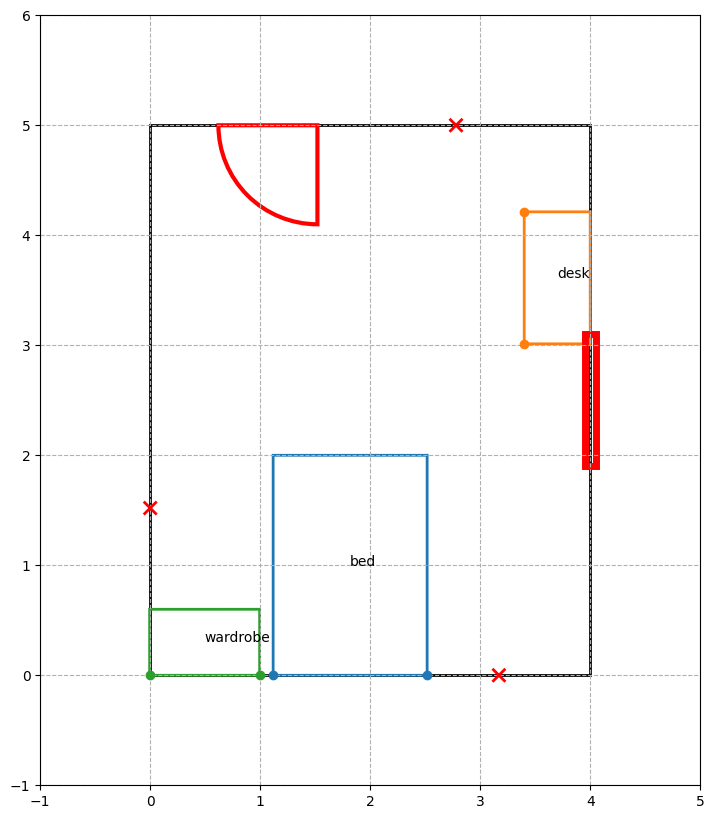

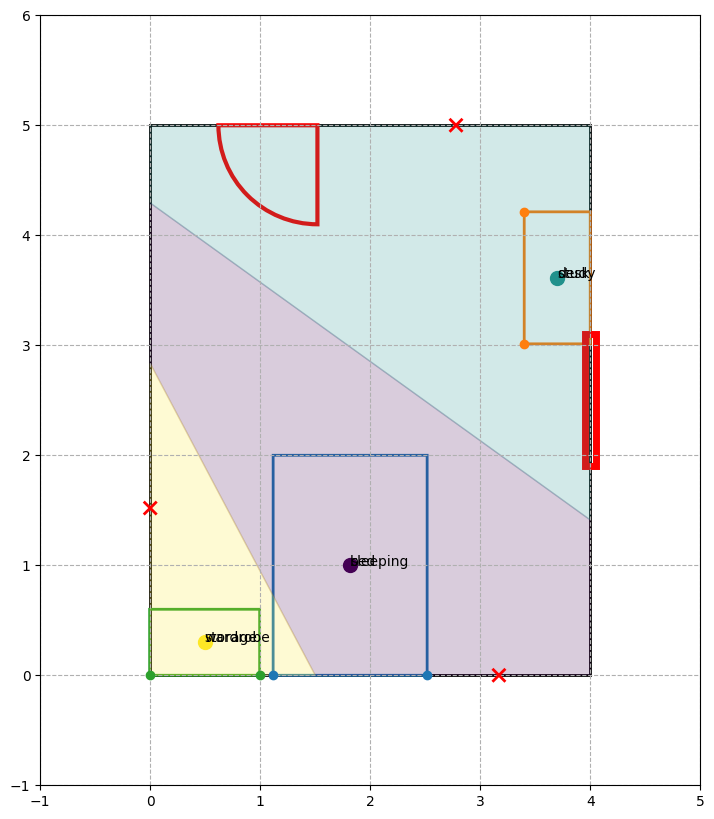

In [120]:
tol = 1e-3
tol2 = 3 
room = local_context[room_name] 
function = local_context['optimize_primary_objects']  
bounds = Bounds([0] * 3 * len(room.moving_objects), [room.width, room.length, 2*np.pi] * len(room.moving_objects))
options = {'maxiter': 500, 'ftol': 1e-6}

max_iters = 25
min_fun = np.Inf
iters = 0
chance = 0
while min_fun > tol:
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi) 
    res = minimize(function, positions, args = (room), method = 'SLSQP', options = options) 
    print(iters, res.fun, res.message)
    if res.fun < min_fun:
        if ind_no_overlap(res.x, room) > num_primary_objects* 1e-2:
            print(f"Objects overlap. Not accepting this solution. Overlap penalty: {ind_no_overlap(res.x, room)}")
        elif ind_in_bounds(res.x, room) > num_primary_objects* 1e-2:
            print(f"Objects are out of bounds. Not accepting this solution. Out of bounds penalty: {ind_in_bounds(res.x, room)}")
        else: 
            min_fun = res.fun
            best_res = res
    if iters == max_iters:
        print("Max number of iterations reached.")
        if min_fun > tol2 and chance == 0:
            print("Allowing more iterations.")
            iters = 0
            chance = 1
            max_iters = 15
            tol = tol2

        else: 
            break
    iters += 1
    
for i in range(len(room.moving_objects)):
    room.moving_objects[i].position = best_res.x[3*i:3*i + 3]
    room.regions[i].x, room.regions[i].y = best_res.x[3*i:3*i + 2]

room.draw()
room.draw(draw_regions = True)

In [121]:
exec(response6)

In [122]:
global_context2 = globals().copy()
local_context2 = {}
exec(response7, global_context2, local_context2)

0 17.357963975934513 Optimization terminated successfully 17.357963975934513
Objects overlap: 0.4423555820649794 
1 23.391573706263408 Optimization terminated successfully 23.391573706263408
Objects are out of bounds: 2.640981333575949
2 18.00462407719408 Optimization terminated successfully 18.00462407719408
Objects are out of bounds: 1.6624823701160834
3 20.312455042651848 Optimization terminated successfully 20.312455042651848
Objects are out of bounds: 0.9500271987863497
4 11.222879958581627 Optimization terminated successfully 11.222879958581627
Objects are out of bounds: 1.741644790109504
5 7.700031560180279 Optimization terminated successfully 7.700031560180279
Objects are out of bounds: 0.5499063815124285
6 23.629222363285418 Optimization terminated successfully 23.629222363285418
Objects are out of bounds: 0.607337172986261
7 11.622330237280119 Optimization terminated successfully 11.622330237280119
Objects are out of bounds: 1.8959479789830707
8 10.619729308705766 Optimizatio

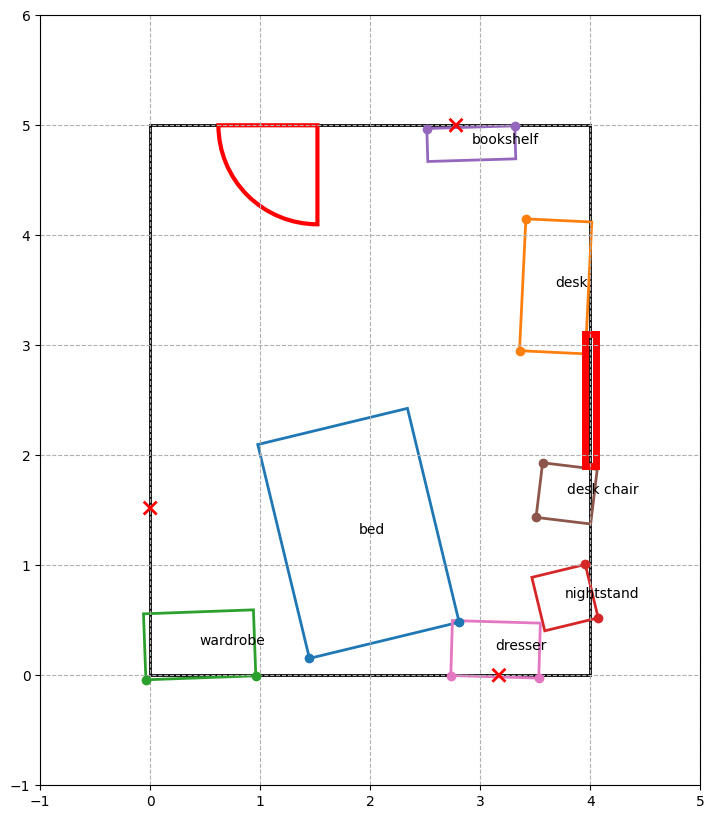

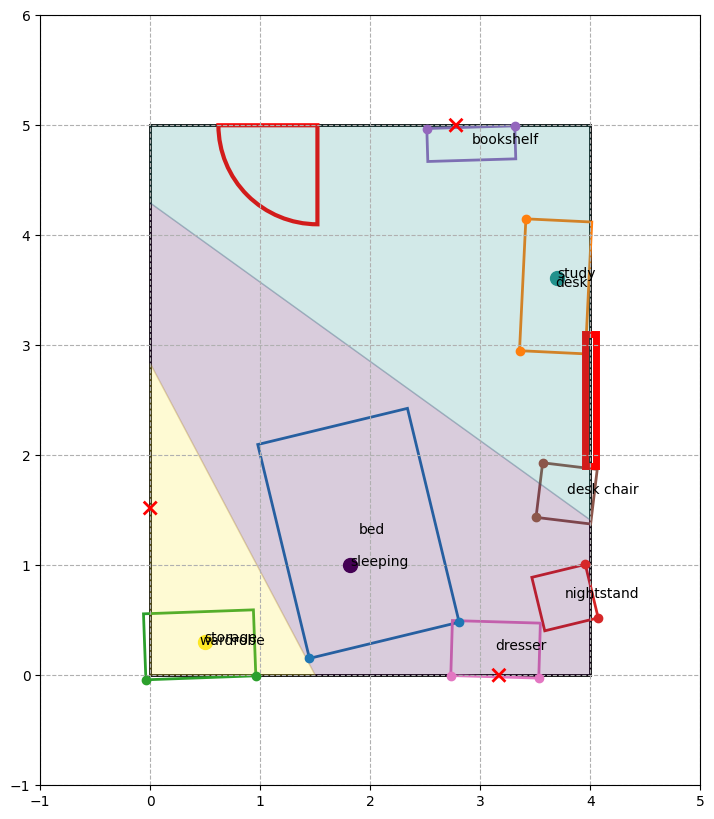

In [123]:
tol = 1e-3
tol2 = 15
function2 = local_context2['optimize_secondary_objects']
options = {'maxiter': 500, 'ftol': 1e-6}
room = local_context[room_name]
max_iters = 30
min_fun = np.Inf
iters = 0
chance = 0
while min_fun > tol:
    positions = np.zeros(3*len(room.moving_objects))
    for i in range(len(room.regions)):
        positions[3*i] = room.moving_objects[i].position[0]
        positions[3*i + 1] = room.moving_objects[i].position[1]
        positions[3*i + 2] = room.moving_objects[i].position[2]
    for i in range(len(room.regions), len(room.moving_objects)):
        positions[3*i] = np.random.uniform(0, room.width)
        positions[3*i + 1] = np.random.uniform(0, room.length)
        positions[3*i + 2] = np.random.uniform(0, 2*np.pi)

    res = minimize(function2, positions, args = (room), method = 'SLSQP', options = options)
    print(iters, res.fun, res.message, function2(res.x, room))
    if res.fun < min_fun:
        if ind_no_overlap(res.x, room) > num_secondary_objects * 5e-2:
            print(f"Objects overlap: {ind_no_overlap(res.x, room)} ")
        elif ind_in_bounds(res.x, room) > num_secondary_objects * 5e-2:
            print(f"Objects are out of bounds: {ind_in_bounds(res.x, room)}")
        else:
            min_fun = res.fun
            best_res = res
    if iters == max_iters:
        print("Max number of iterations reached.")
        if min_fun > tol2 and chance == 0:
            print("Allowing more iterations")
            iters = 0
            chance = 1
            max_iters = 15
            tol = tol2
        else:
            break
    iters += 1

if ind_in_bounds(res.x, room) > 1 or ind_no_overlap(res.x, room) > 1:
    print("No Solution Found.")

else:
    for i in range(len(room.moving_objects)):
        room.moving_objects[i].position = best_res.x[3*i:3*i + 3]
    room.draw()
    room.draw(draw_regions = True)